# Prevendo a Rotatividade de Clientes em Telecomunicações

A operadora de comunicações Interconnect gostaria de ser capaz de predizer a rotatividade de seus clientes. Se for descoberto que um usuário está planejando trocar de operadora, a empresa oferecerá-lhe códigos promocionais e opções de plano especiais. A equipe de marketing da Interconnect coletou alguns dados pessoais da sua clientela, incluindo a informação sobre seus planos e contratos.

# Sumário
1. [Iniciação](#1)
2. [Pré-processamento de Dados](#2)
3. [Análise Exploratória de Dados](#3)
4. [Treinamento dos Modelos](#4)
5. [Conclusão](#5)

## Iniciação <a name='1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Iniciarei observando os dados nos datasets e ponderando as melhores opções a serem feitas em cada um

In [3]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


O tipo das colunas `BeginDate` e `EndDate` serão transformados em datetime, `PaperlessBilling` e `PaymentMethod` em colunas do tipo categórica e `TotalCharges` para float

In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Todas as colunas, exceto por `CustomerID`, serão mudadas para o tipo categórico

In [5]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Novamente, todas mudarão para o tipo categórico exceto por `CustomerID`

In [6]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


A coluna `MultipleLines` mudará para categórica

Observado as tabelas, notamos a necessidade de processamento dos dados para uma análise mais detalhada. Como todas as tabelas possuem `customerID`, faremos um `merge` que resultará em valores ausentes devido à diferença de linhas. Após o tratamento dos mesmos, iniciaremos a análise exploratória com a verificação do desbalanceamento de classe e uma análise da correlação para tirar melhores conclusões.

## Pré-processamento de Dados <a name='2'></a>

### Contract

Iniciarei com os dados de `contract` mudando os pontos citados anteriormente e extrairei da coluna `EndDate` a informação de churn, sendo 0 como um cliente que permanace com o serviço e 1 como não. Essa coluna será usada para treinar o modelo, ou seja, será o target.

In [7]:
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('category')
contract['PaymentMethod'] = contract['PaymentMethod'].astype('category')
contract['Type'] = contract['Type'].astype('category')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['Churn'] = (contract['EndDate'] != 'No').astype('int')

Agora iremos substituir `No` da coluna `EndDate` com a data atual que é 21 de fevereiro de 2020 e mudar o formato de data das duas colunas.

In [8]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-21 00:00:00')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   int32         
dtypes: category(3), datetime64[ns](2), float64(2), int32(1), object(1)
memory usage: 323.8+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,2020-02-21,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-21,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-21,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [9]:
contract[contract['EndDate'] == 'No']['EndDate'].count()

0

Confirmamos que a substituição foi feita corretamente

Para obter insights melhores sobre o comportamento dos clientes, será criada uma coluna com os dias ativos de contrato do cliente. A coluna `Day` será o resultado da diferença da data atual e do início do contrato.

In [10]:
contract['Days'] = (contract['EndDate'] - contract['BeginDate']).dt.days

Com as informações necessárias para análise, podemos excluir as colunas com as datas do contrato.

In [11]:
contract_final = contract.drop(['BeginDate', 'EndDate'], axis=1)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   category      
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   Days              7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float64(2), int32(1), int64(1), object(1)
memory usage: 378.9+ KB


Agora só resta excluir os valores ausentes causados pela conversão.

In [12]:
contract_final.dropna(inplace=True)
contract_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   Type              7032 non-null   category
 2   PaperlessBilling  7032 non-null   category
 3   PaymentMethod     7032 non-null   category
 4   MonthlyCharges    7032 non-null   float64 
 5   TotalCharges      7032 non-null   float64 
 6   Churn             7032 non-null   int32   
 7   Days              7032 non-null   int64   
dtypes: category(3), float64(2), int32(1), int64(1), object(1)
memory usage: 323.2+ KB


### Personal

Novamente o mesmo processo

In [13]:
personal['gender'] = personal['gender'].astype('category')
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('category')  
personal['Partner'] = personal['Partner'].astype('category')
personal['Dependents'] = personal['Dependents'].astype('category')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   customerID     7043 non-null   object  
 1   gender         7043 non-null   category
 2   SeniorCitizen  7043 non-null   category
 3   Partner        7043 non-null   category
 4   Dependents     7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


## Mesclando Tabelas

In [14]:
merge_1 = pd.merge(personal, contract_final, how='left', on='customerID')
merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   float64 
 11  Days              7032 non-null   float64 
dtypes: category(7), float64(4), object(1)
memory usage: 379.2+ KB


Tratando os valores ausentes causados pela diferença de linhas nos dataframes

In [15]:
merge_1.dropna(inplace=True)
merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   float64 
 11  Days              7032 non-null   float64 
dtypes: category(7), float64(4), object(1)
memory usage: 378.6+ KB


In [16]:
merge_2 = pd.merge(merge_1, phone, how='left', on='customerID')
merge_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   float64 
 11  Days              7032 non-null   float64 
 12  MultipleLines     6352 non-null   object  
dtypes: category(7), float64(4), object(2)
memory usage: 433.6+ KB


In [17]:
data_final = pd.merge(merge_2, internet, how='left', on='customerID')
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   float64 
 11  Days              7032 non-null   float64 
 12  MultipleLines     6352 non-null   object  
 13  InternetService   5512 non-null   object  
 14  OnlineSecurity    5512 non-null   object  
 15  OnlineBackup      5512 non-null   object  
 16  DeviceProtection  5512 n

In [18]:
data_final['Churn'] = data_final['Churn'].astype('int')

Podemos agora proceder à substituição desses valores ausentes. Visto que os usuários que possuem lacunas em suas linhas não são assinantes dos serviços relacionados a essas colunas, é possível substituir os valores ausentes por `No`.

In [19]:
na_cols = data_final.columns[data_final.dtypes == 'object']
data_final[na_cols] = data_final[na_cols].fillna('No')

data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   int32   
 11  Days              7032 non-null   float64 
 12  MultipleLines     7032 non-null   object  
 13  InternetService   7032 non-null   object  
 14  OnlineSecurity    7032 non-null   object  
 15  OnlineBackup      7032 non-null   object  
 16  DeviceProtection  7032 n

Convertendo as colunas no tipo categórico

In [20]:
data_final['InternetService'] = data_final['InternetService'].astype('category')
data_final['OnlineSecurity'] = data_final['OnlineSecurity'].astype('category')
data_final['OnlineBackup'] = data_final['OnlineBackup'].astype('category')
data_final['DeviceProtection'] = data_final['DeviceProtection'].astype('category')
data_final['TechSupport'] = data_final['TechSupport'].astype('category')
data_final['StreamingTV'] = data_final['StreamingTV'].astype('category')
data_final['StreamingMovies'] = data_final['StreamingMovies'].astype('category')
data_final['MultipleLines'] = data_final['MultipleLines'].astype('category')

data_final.info()
data_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   Type              7032 non-null   category
 6   PaperlessBilling  7032 non-null   category
 7   PaymentMethod     7032 non-null   category
 8   MonthlyCharges    7032 non-null   float64 
 9   TotalCharges      7032 non-null   float64 
 10  Churn             7032 non-null   int32   
 11  Days              7032 non-null   float64 
 12  MultipleLines     7032 non-null   category
 13  InternetService   7032 non-null   category
 14  OnlineSecurity    7032 non-null   category
 15  OnlineBackup      7032 non-null   category
 16  DeviceProtection  7032 n

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,51.0,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0,1056.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1391.0,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0,No,Fiber optic,No,No,No,No,No,No


Com as informações processadas podemos seguir para a análise exploratória de dados

## Análise Exploratória de Dados <a name='3'></a>

### Desbalancemanto de Classes

Começaremos analisando o desequilibrio das classes

<AxesSubplot:>

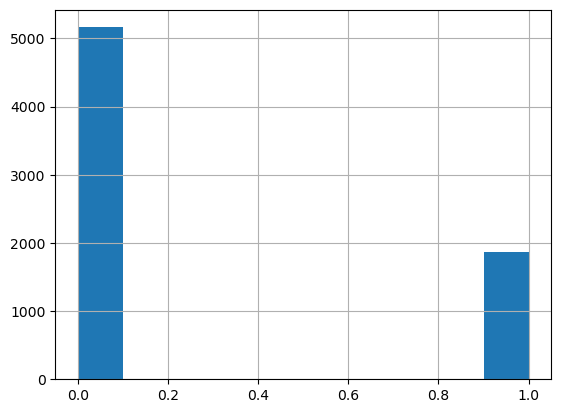

In [21]:
data_final['Churn'].hist()

Observamos que um pouco mais de 5000 clientes ficaram e menos de 2000 saíram. Essa desproporcionalidade nos dados deverá ser tratada posteriormente para criar um modelo sem uma alta variância, overfitting.

### Relação Característica Churn

Serão realizadas plotagens de gráficos para entender a relação das características sobre o churn

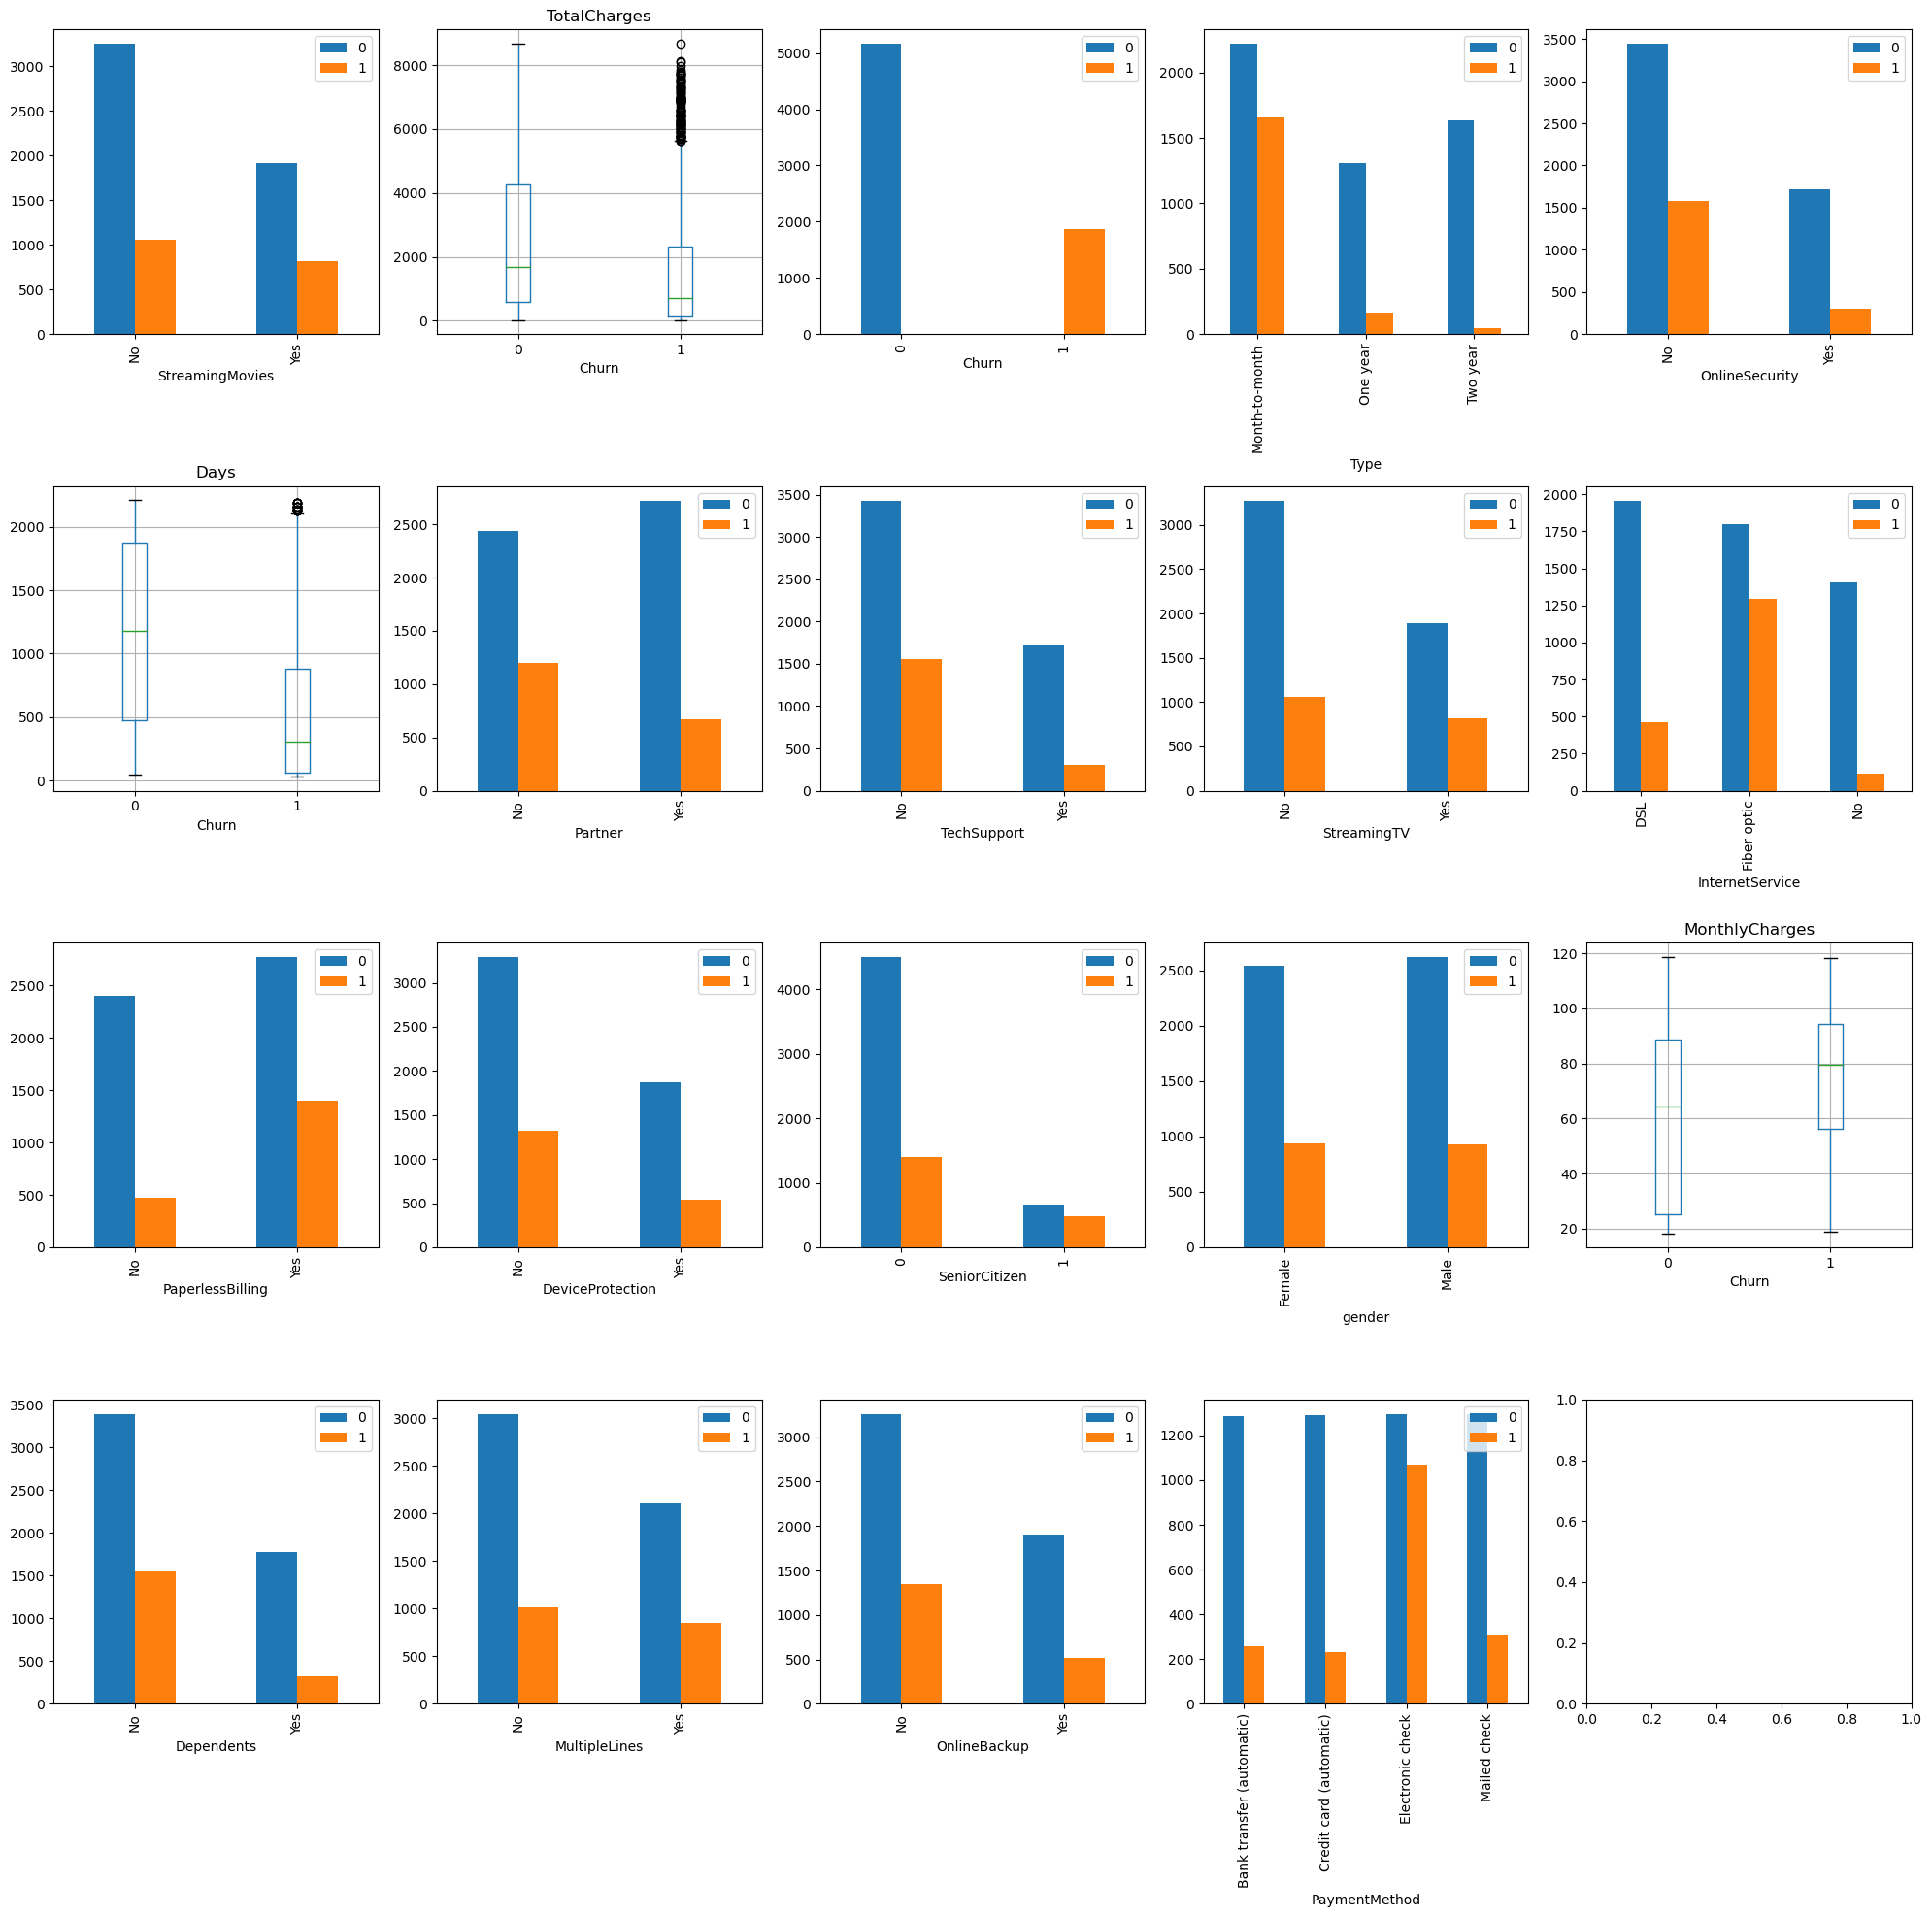

In [22]:
fig, axs = plt.subplots(4, len(data_final.columns) // 4, figsize=(20,20))
#cria uma imagem com 4 linhas de grade e colunas que são calculadas dividindo o número de colunas no 
#DataFrame pelo número desejado de subplots por linha, neste caso 4, com um tamanho de 20 por 20
axs = axs.flatten() #transforma a matriz multidimensional em unidimensional para iterar mais facilmente

cols = list(set(data_final.columns) - set(['customerID'])) 
#cria uma lista que contém todas as colunas exceto customerID

for col, ax in zip(cols, axs):
    if data_final[col].dtype=='float64':
        data_final.boxplot(column=col, by='Churn', ax=ax)
        plt.suptitle('')
    else:
        df = data_final.groupby([col, 'Churn'])['Churn'].count().unstack()
        df.plot(kind='bar', stacked=False, ax=ax)
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Pelos gráficos podemos tirar os seguintes insights sobre as pessoas que saíram:
- Não tinham faturamento por papel e usavam como método de pagamento o cheque eletrônico
- Eram associados mensais
- Não eram cidadãos seniores
- Não tinham multiplos serviços de assinatura de internet

As cargas mensais são em média 80 dólares com poucos dias de contrato baseado no boxplot `Days`, portanto, pode-se concluir que são usuários novos. Ao observar o gráfico `TotalCharges` vemos também que estes usuários faziam menos recargas no total, porém constatamos mais outliers comparado a `Days`

### Matrix de Correlação

In [23]:
data_final.corr()

,MonthlyCharges,TotalCharges,Churn,Days
MonthlyCharges,1.000000,0.651065,0.192858,0.243399
TotalCharges,0.651065,1.000000,-0.199484,0.824663
Churn,0.192858,-0.199484,1.000000,-0.364770
Days,0.243399,0.824663,-0.364770,1.000000


Observa-se que não existe uma correlação significativa com o churn em nenhuma das características numéricas. Porém há uma forte entre os dias e o total de cargas

Veremos agora as mensalidades dos assinantes dos serviços de telefone e internet e, para cada serviço, compararemos sua distribuição entre quem saiu e quem não saiu

### Cobrança Mensal dos Clientes do Serviço Telefônico

In [24]:
phone_users = data_final[data_final['customerID'].isin(phone['customerID'])]
phone_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6352 entries, 1 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        6352 non-null   object  
 1   gender            6352 non-null   category
 2   SeniorCitizen     6352 non-null   category
 3   Partner           6352 non-null   category
 4   Dependents        6352 non-null   category
 5   Type              6352 non-null   category
 6   PaperlessBilling  6352 non-null   category
 7   PaymentMethod     6352 non-null   category
 8   MonthlyCharges    6352 non-null   float64 
 9   TotalCharges      6352 non-null   float64 
 10  Churn             6352 non-null   int32   
 11  Days              6352 non-null   float64 
 12  MultipleLines     6352 non-null   category
 13  InternetService   6352 non-null   category
 14  OnlineSecurity    6352 non-null   category
 15  OnlineBackup      6352 non-null   category
 16  DeviceProtection  6352 n

Distribuição das cobranças mensais sobre os clientes de telefone

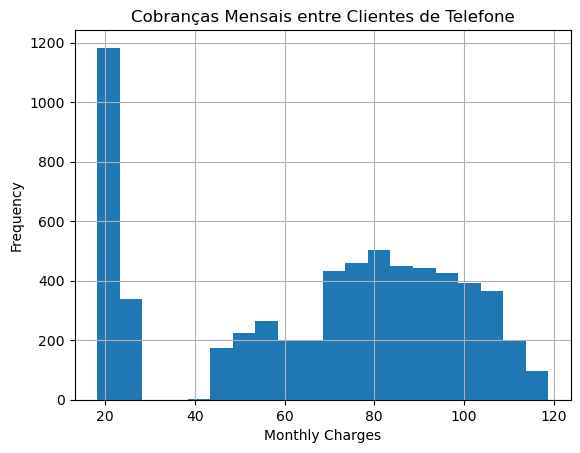

In [25]:
phone_users['MonthlyCharges'].hist(bins=20)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Cobranças Mensais entre Clientes de Telefone')
plt.show()

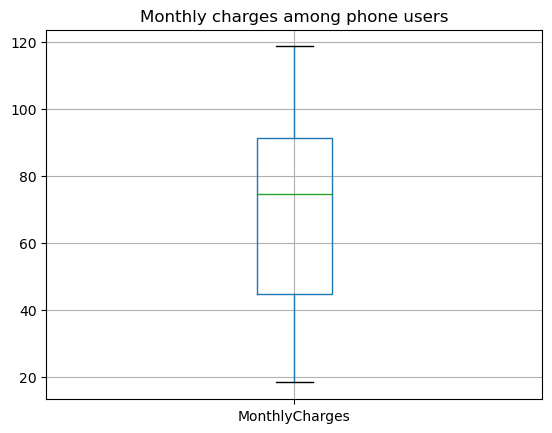

In [26]:
phone_users.boxplot(column='MonthlyCharges')
plt.title('Monthly charges among phone users')
plt.show()

In [27]:
phone_users['MonthlyCharges'].describe()

count    6352.000000
mean       67.239625
std        30.438439
min        18.250000
25%        44.787500
50%        74.700000
75%        91.250000
max       118.750000
Name: MonthlyCharges, dtype: float64

Um usuário característico de telefone é normalmente cobrado entre cerca de 45 e cerca de 91. Todavia, segundo o histograma, há por volta de 1500 pessoas que pagam entre 20 e 30 cargas mensais.

 Distribuição de quem saiu e quem ficou

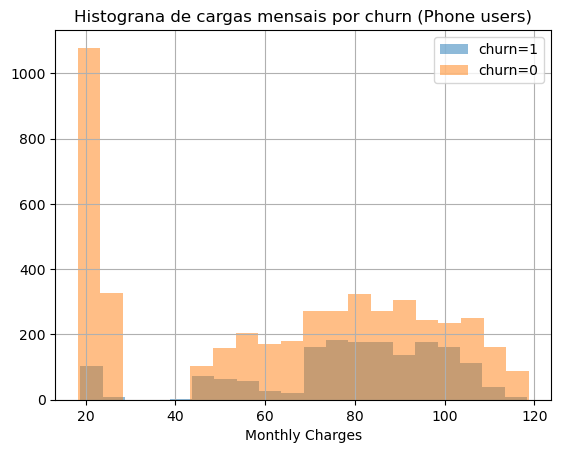

In [28]:
phone_users[phone_users['Churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
phone_users[phone_users['Churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histograna de cargas mensais por churn (Phone users)')
plt.show()

As distribuições são bastante semelhantes, embora para quem saiu seja muito menor

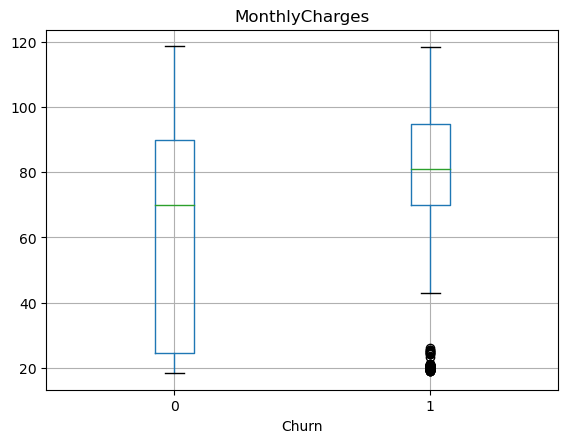

In [29]:
phone_users.boxplot(column='MonthlyCharges', by='Churn')
plt.suptitle('')
plt.show()

Constatamos que os que saíram normalmente pagaram mensalidades mais altas do que aqueles que permaneceram

In [30]:
print('Distribuição de Cargas Mensais para Desistentes',
      phone_users[phone_users['Churn']==1]['MonthlyCharges'].describe())
print('')
print('Distribuição de Cargas Mensais para os que ficaram',
      phone_users[phone_users['Churn']==0]['MonthlyCharges'].describe())

Distribuição de Cargas Mensais para Desistentes count    1699.000000
mean       78.134255
std        22.567643
min        18.850000
25%        69.975000
50%        80.950000
75%        94.850000
max       118.350000
Name: MonthlyCharges, dtype: float64

Distribuição de Cargas Mensais para os que ficaram count    4653.000000
mean       63.261552
std        31.934310
min        18.250000
25%        24.500000
50%        69.900000
75%        90.050000
max       118.750000
Name: MonthlyCharges, dtype: float64


Aqueles que saíram normalmente pagaram entre aproximadamente 70 e 95. Enquanto aqueles que permaneceram normalmente pagavam entre aproximadamente 24 e 90

### Cobrança Mensal dos Cliente do Serviço de Internet

O mesmo processo feito para o serviço telefônico será repetido para o serviço de internet

In [31]:
internet_users = data_final[data_final['customerID'].isin(internet['customerID'])]
internet_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5512 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5512 non-null   object  
 1   gender            5512 non-null   category
 2   SeniorCitizen     5512 non-null   category
 3   Partner           5512 non-null   category
 4   Dependents        5512 non-null   category
 5   Type              5512 non-null   category
 6   PaperlessBilling  5512 non-null   category
 7   PaymentMethod     5512 non-null   category
 8   MonthlyCharges    5512 non-null   float64 
 9   TotalCharges      5512 non-null   float64 
 10  Churn             5512 non-null   int32   
 11  Days              5512 non-null   float64 
 12  MultipleLines     5512 non-null   category
 13  InternetService   5512 non-null   category
 14  OnlineSecurity    5512 non-null   category
 15  OnlineBackup      5512 non-null   category
 16  DeviceProtection  5512 n

Distribuição de cargas mensais para os clientes do serviço de internet

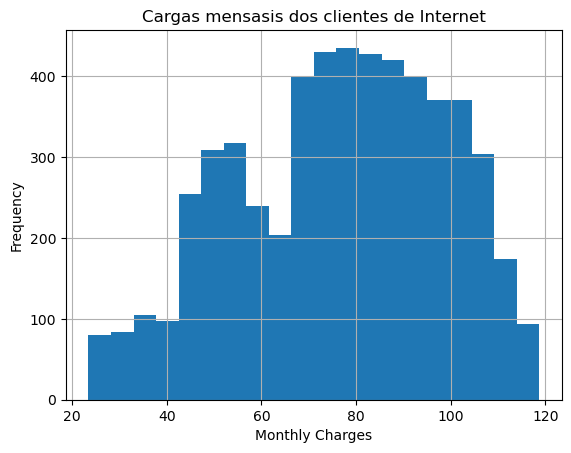

In [32]:
internet_users['MonthlyCharges'].hist(bins=20)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Cargas mensasis dos clientes de Internet')
plt.show()

Notamos 2 picos que estão localizados em torno de 50 e o outro em torno de 80. A distribuição está inclinada para a direita

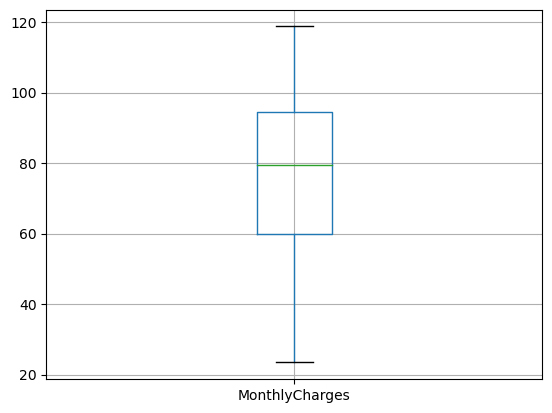

In [33]:
internet_users.boxplot(column='MonthlyCharges')
plt.show()

In [34]:
internet_users['MonthlyCharges'].describe()

count    5512.000000
mean       76.855053
std        21.929331
min        23.450000
25%        59.950000
50%        79.500000
75%        94.450000
max       118.750000
Name: MonthlyCharges, dtype: float64

Os usuários de Internet normalmente são cobrados entre cerca de 60 e 95 mensalmente. Agora dividiremos a distribuição por churn

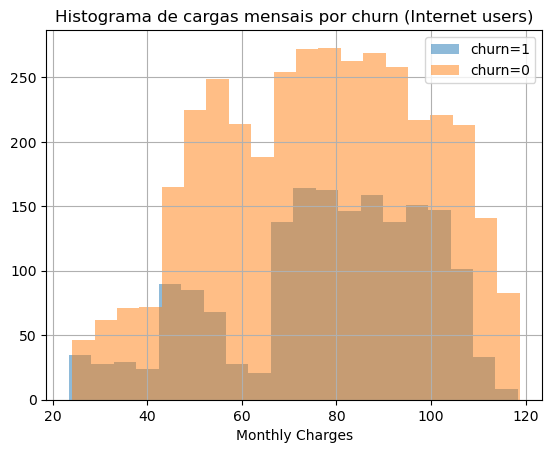

In [35]:
internet_users[internet_users['Churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
internet_users[internet_users['Churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histograma de cargas mensais por churn (Internet users)')
plt.show()

Novamente notamos distribuições semelhantes, embora as frequências variem a maioria das pessoas permaneceram

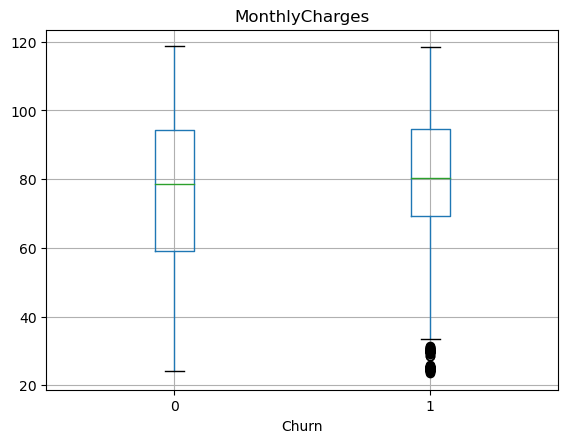

In [36]:
internet_users.boxplot(column='MonthlyCharges', by='Churn')
plt.suptitle('')
plt.show()

In [37]:
print('Distribuição de Cargas Mensais para Desistentes',
      internet_users[internet_users['Churn']==1]['MonthlyCharges'].describe())
print('')
print('Distribuição de Cargas Mensais para os que ficaram',
      internet_users[internet_users['Churn']==0]['MonthlyCharges'].describe())

Distribuição de Cargas Mensais para Desistentes count    1756.000000
mean       77.920985
std        21.144147
min        23.450000
25%        69.350000
50%        80.450000
75%        94.650000
max       118.350000
Name: MonthlyCharges, dtype: float64

Distribuição de Cargas Mensais para os que ficaram count    3756.000000
mean       76.356709
std        22.272199
min        24.150000
25%        59.137500
50%        78.725000
75%        94.312500
max       118.750000
Name: MonthlyCharges, dtype: float64


Diferente da outra distribuição, notamos um equilíbrio maior na carga entre os que saíram e ficaram. Aqueles que saíram normalmente pagaram entre aproximadamente 69 e 95. Embora aqueles que permaneceram normalmente pagassem entre cerca 59 e 94

Em resumo, tanto os utilizadores de internet como os de telefone, em geral, pagavam mensalidades mais elevadas quando cancelavam o serviço

- Conclusão

### Plano Geral de Resolução

Passo 1: Importação e Análise Inicial dos Dados
- Importe os dados para o notebook;
- Realize uma análise inicial sobre os tipos de dados presentes em cada tabela para compreender melhor o conjunto de dados.

Passo 2: Pré-processamento dos Dados
- Faça os ajustes nos tipos de dados identificados na análise anterior;
- Crie novas colunas extraindo informações de outras;
- Execute as transformações apenas nas tabelas `contract` e `personal` devido à criação de valores ausentes após a mesclagem das tabelas, tornando o preenchimento mais eficiente;
- Após a mesclagem, verifique se todos os dados foram transformados adequadamente e finalize esta etapa.

Passo 3: Análise Exploratória de Dados
- Inicie a análise exploratória verificando o balanceamento da classe alvo;
- Plote gráficos relacionando cada característica com o churn para uma compreensão mais detalhada do dataframe;
- Tire conclusões com base nos gráficos e nas observações feitas;
- Analise a matriz de correlação;
- Investigue as cargas mensais dos contratantes do serviço telefônico e de internet para fazer uma conclusão geral sobre os dados.

### Perguntas de Esclarecimento

_**Quais são os tipos de informações específicas extraídas das tabelas `contract` e `personal` para a criação das colunas adicionais durante o pré-processamento?**_
- Foi extraída a informação sobre os dias de contrato do cliente (Days) e se o cliente cancelou ou não o contrato (churn).

_**Quais são os principais insights ou conclusões derivados da análise exploratória de dados, especialmente em relação à relação entre as mensalidades mais altas e o cancelamento do serviço?**_
- Isso sugere que os clientes que pagam mais podem estar mais propensos a cancelar o serviço. Como a maioria dos clientes que saíram pagam eletronicamente este pode ser a causa do problema, portanto, é recomendável analisar o funcionamento deste método.

_**Pode ser fornecida uma explicação adicional sobre como a forte correlação entre os dias e o total de cargas foi investigada e como isso influenciou as descobertas na análise?**_
- Isso significa que clientes que usam o serviço por mais dias tendem a realizar mais cargas. Essa descoberta pode ter implicações importantes, pois indica que a frequência de uso pode estar relacionada ao volume de cargas, o que pode influenciar diretamente nos resultados financeiros da empresa. Portanto, é importante investigar estratégias para incentivar a utilização mais frequente do serviço a fim de aumentar o volume de cargas e, assim, melhorar o desempenho financeiro da empresa.

# Treinamento dos Modelos <a name='4'></a>

Começaremos processando o dataset excluindo a coluna `customerID` já que não será mais utilizada e `Days` porque deve ser uma informação desconhecida na hora da predição.

In [38]:
data_final = data_final.drop(['customerID', 'Days'], axis=1)

Separando as características do target

In [39]:
X = data_final.drop('Churn', axis=1)
y = data_final['Churn']

Selecionando os dados categóricos e numéricos

In [40]:
categorical_columns = X.columns[X.dtypes == 'category']
numeric_columns = X.columns[X.dtypes != 'category']

print(categorical_columns)
print(numeric_columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies'],
      dtype='object')
Index(['MonthlyCharges', 'TotalCharges'], dtype='object')


## Modelos

### Logistic Regression

Criando as etapas de pré-processamento para a validação

In [41]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numeric_transformer, numeric_columns)
    ])

Criando o modelo e usando a validação cruzada estratificada para manter a proporção das classes

In [42]:
model = LogisticRegression(class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

Para evitar o vazamento de dados ao realizar encoding no dataset antes de usá-lo, vamos garantir que o encoding seja aplicado separadamente a cada fold durante o processo de validação cruzada.

In [43]:
for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    # Treinando o modelo no conjunto de treinamento do fold atual
    clf.fit(X_train, y_train)

    # Previsões no conjunto de teste do fold atual
    y_pred = clf.predict(X_test)

    # AUC-ROC do fold atual
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

# AUC-ROC médio dos folds
print(f"AUC-ROC médio: {np.mean(auc_scores):.4f}")

AUC-ROC médio: 0.7590


### Random Forest

In [44]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

auc_scores = []

for max_depth in max_depth_list:
    fold_aucs = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        model = RandomForestClassifier(n_estimators=40, max_depth=max_depth, random_state=42, class_weight='balanced')

        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])

        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        auc = roc_auc_score(y_test, y_pred)
        fold_aucs.append(auc)

    # Média das AUCs dos folds para o valor de max_depth atual
    mean_auc = np.mean(fold_aucs)
    auc_scores.append((max_depth, mean_auc))

# max_depth com melhor média de AUC-ROC
best_max_depth, best_auc = max(auc_scores, key=lambda x: x[1])

print(f"Melhor max_depth: {best_max_depth}")
print(f"AUC-ROC médio correspondente: {best_auc:.4f}")

Melhor max_depth: 7
AUC-ROC médio correspondente: 0.7664


### Catboost

In [45]:
data_final['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [46]:
model = CatBoostClassifier(verbose=False, random_state=42, scale_pos_weight=3)
auc_scores = []
recall_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc_scores.append(auc)
    recall_scores.append(rec)

print(f"AUC-ROC médio: {np.mean(auc_scores):.4f}")
print(f"Recall médio: {np.mean(recall_scores):.4f}")

AUC-ROC médio: 0.7543
Recall médio: 0.7539


### LightGBM

In [47]:
model = LGBMClassifier(random_state=42, scale_pos_weight=3)
auc_scores = []
recall_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc_scores.append(auc)
    recall_scores.append(rec)

print(f"AUC-ROC médio: {np.mean(auc_scores):.4f}")
print(f"Recall médio: {np.mean(recall_scores):.4f}")

AUC-ROC médio: 0.7506
Recall médio: 0.7550


## Teste Final

O modelo que se destacou na validação cruzada foi o Random Forest, com uma pontuação AUC-ROC de `0,7664`. Procederemos a avaliação do desempenho deste modelo no conjunto de testes utilizando o hiperparâmetro em que o max_depth é definido como 7.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
model = RandomForestClassifier(n_estimators=40, max_depth=7, random_state=42, class_weight='balanced')

In [50]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [52]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
probab = clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probab[:,1])
acc = accuracy_score(y_test, pred)
rec = recall_score(y_test, pred)

print('AUC-ROC =', auc)
print('Accuracy =', acc)
print('Recall =', rec)

AUC-ROC = 0.8295851528384279
Accuracy = 0.7417519908987485
Recall = 0.759825327510917


# Conclusão <a name='5'></a>

Examinamos os dados e identificamos que os clientes que optaram por encerrar seus contratos geralmente estavam pagando mensalidades mais elevadas. A maioria dos clientes que cancelou o serviço fazia seus pagamentos eletronicamente, o que sugere a necessidade de investigar esse sistema em particular. Além disso, realizamos treinamento com diversos modelos, incluindo Logistic Regression, Random Forest, CatBoost e LightGBM. Após aplicar uma pipeline para pré-processar os dados dentro da validação cruzada, observamos que o modelo Random Forest obteve a melhor pontuação `0,7664` no conjunto de treinamento. Ao avaliá-lo no conjunto de teste, alcançamos uma  pontuação AUC-ROC de ~`0,82959` e uma taxa de precisão de ~`74,18%`.